In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


In [2]:
# 打开 ROOT 文件，载入 events tree
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
#Energy_Train=(0.5,)
Energy_Val=(0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    #MCP_px = tree["MCParticles.momentum.x"].array(library="np")
    #MCP_py = tree["MCParticles.momentum.y"].array(library="np")
    #MCP_pz = tree["MCParticles.momentum.z"].array(library="np")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    #print to check
    # sorted_indices = np.argsort(calo_layer[0])
    # energy_sorted = energy[0][sorted_indices].to_numpy()
    # layer_sorted = calo_layer[0][sorted_indices].to_numpy()
    # posz_sorted = pos_z[0][sorted_indices].to_numpy()
    # print("Event 0 (sorted by layer):")
    # for l, e, z in zip(layer_sorted, energy_sorted, posz_sorted):
    #     print(f"  Layer {l:2d} | Energy = {e:.5f} | PosZ = {z:.5f }")

    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)

    #print("Event 0:")
    #for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
    #    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_validate, N_layers_validate, E_truth_validate = ReadData_Energy(DataPath_Validate,Energy_Val)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/3.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/4.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/6.5GeV.root

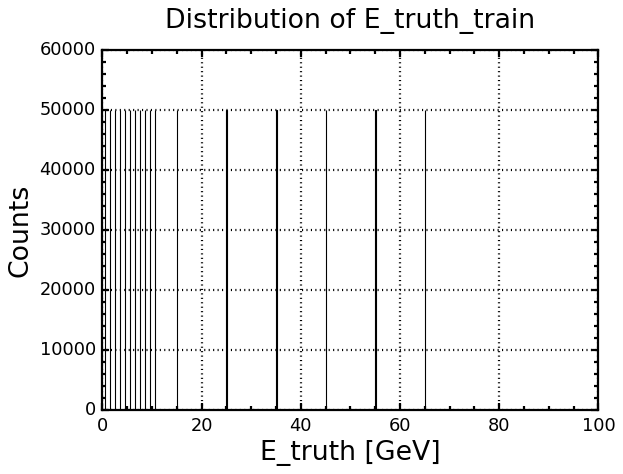

In [3]:
#Read Data
plt.figure(figsize=fig_size)
plt.hist(E_truth_train, bins=1000, range=(0, 100), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.xlim(0, 100)
plt.ylabel("Counts")
plt.title("Distribution of E_truth_train")
plt.grid(True)
plt.show()

In [4]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    print("shape", E_layers.shape, N_layers.shape, E_truth.shape)
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_validate, N_layers_validate, E_sum_val, N_sum_val, E_truth_validate = Event_Selection(E_layers_validate, N_layers_validate, E_truth_validate)

shape (850000, 30) (850000, 30) (850000,)
shape (1000100, 30) (1000100, 30) (1000100,)
shape (50000, 30) (50000, 30) (50000,)


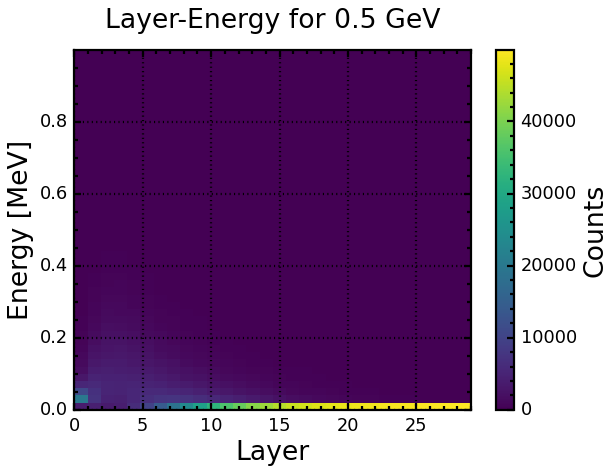

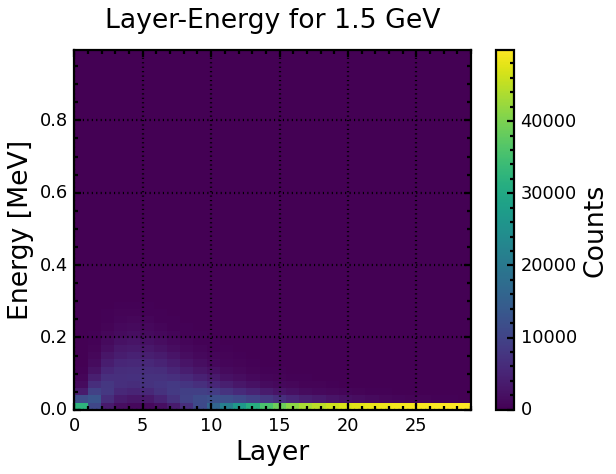

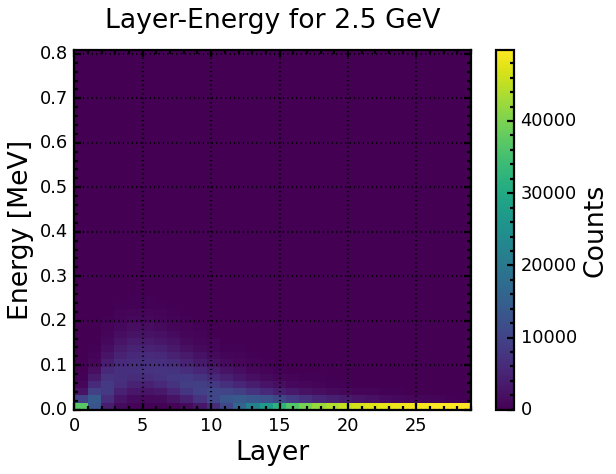

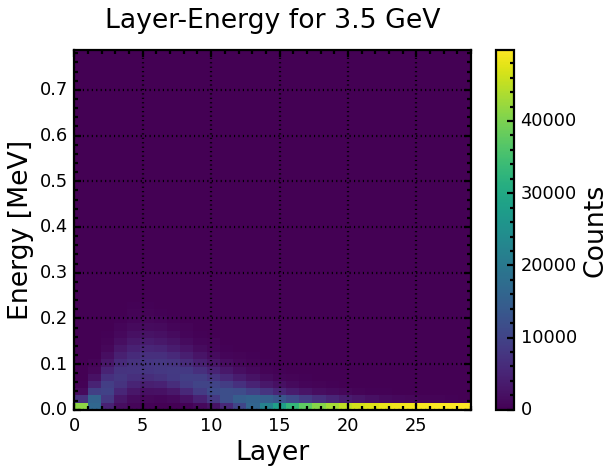

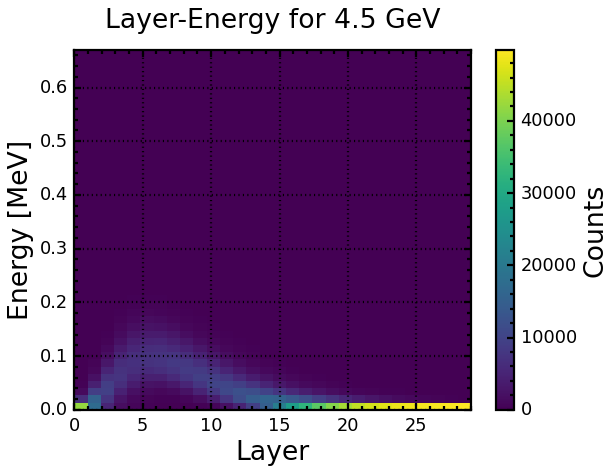

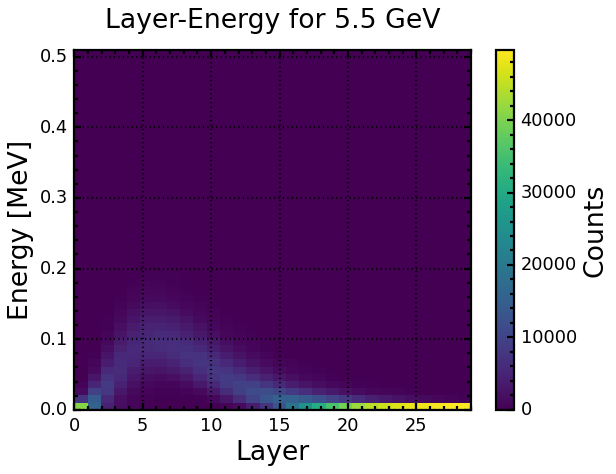

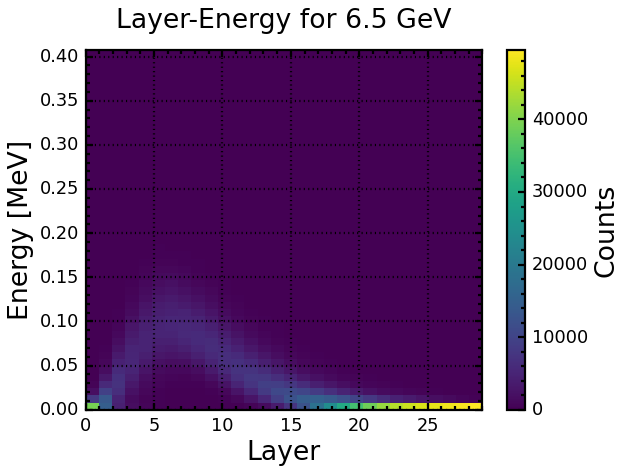

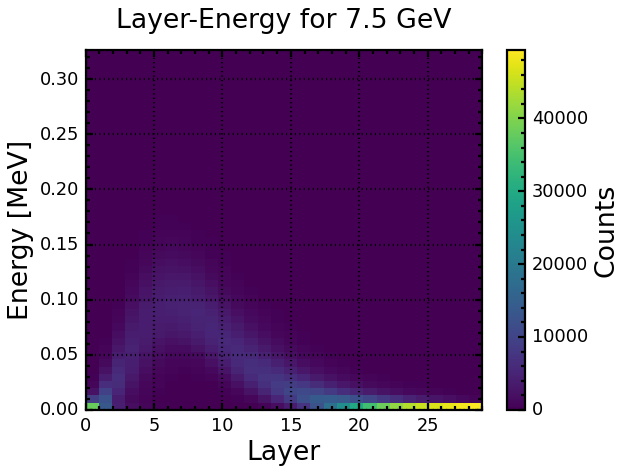

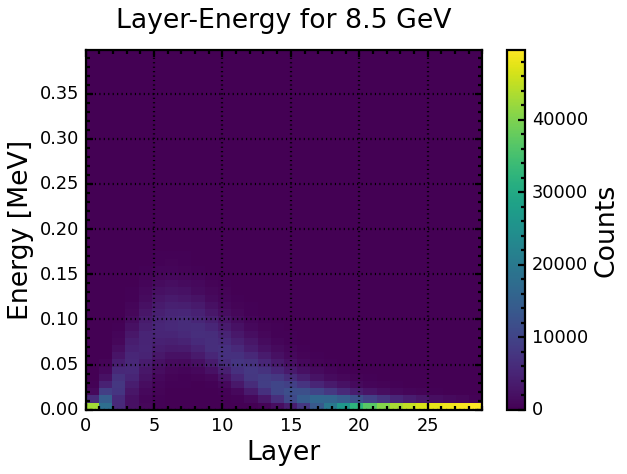

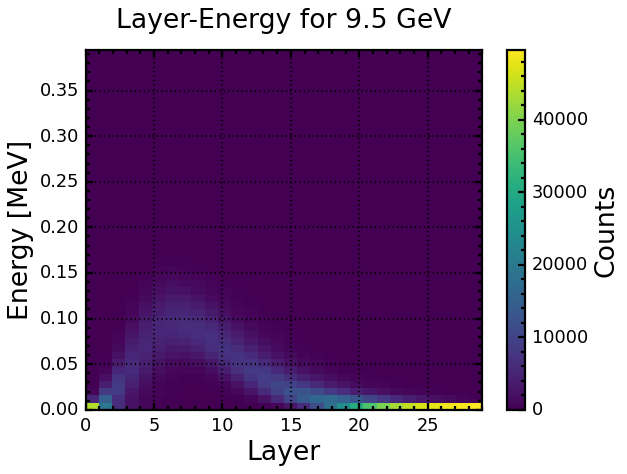

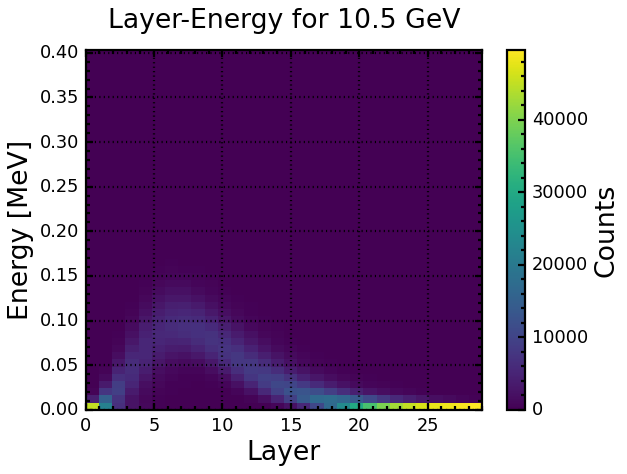

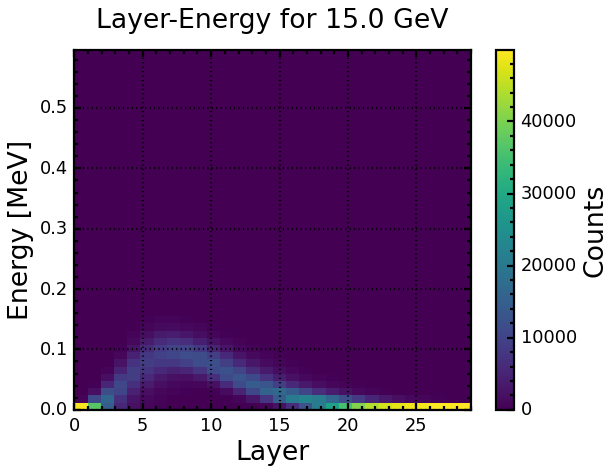

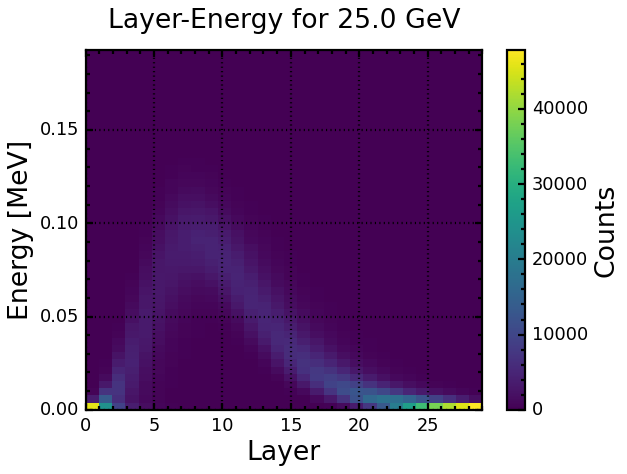

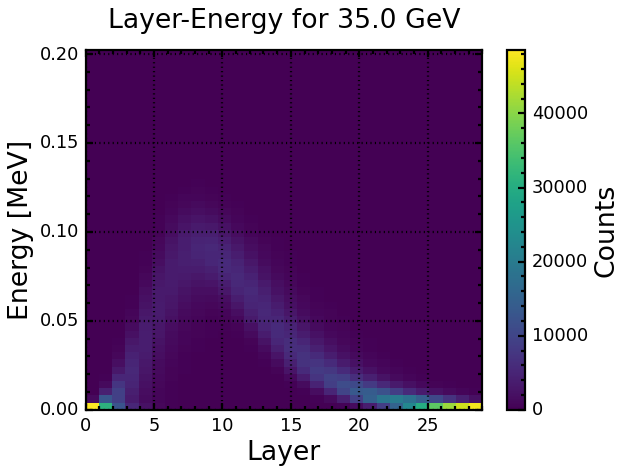

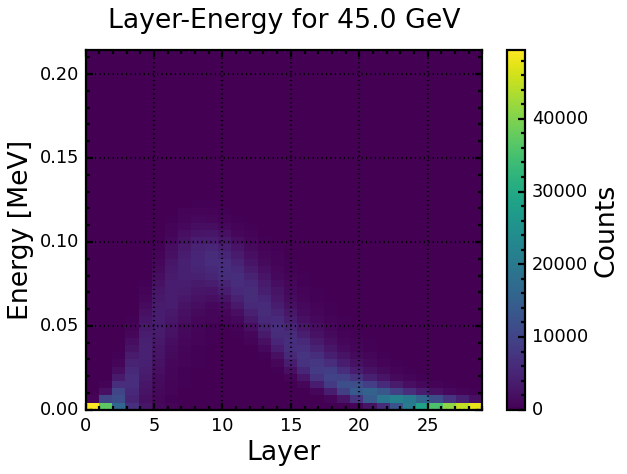

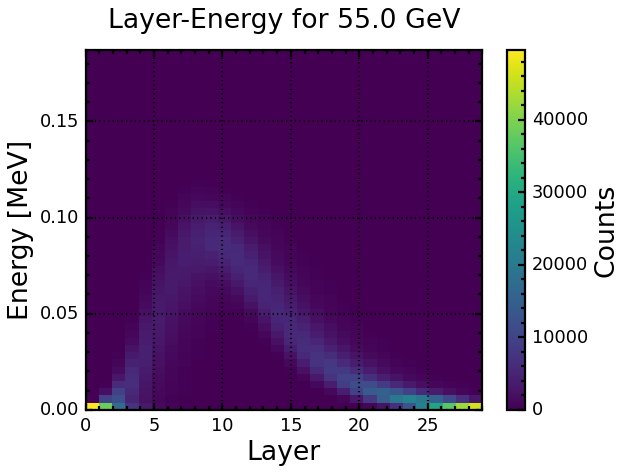

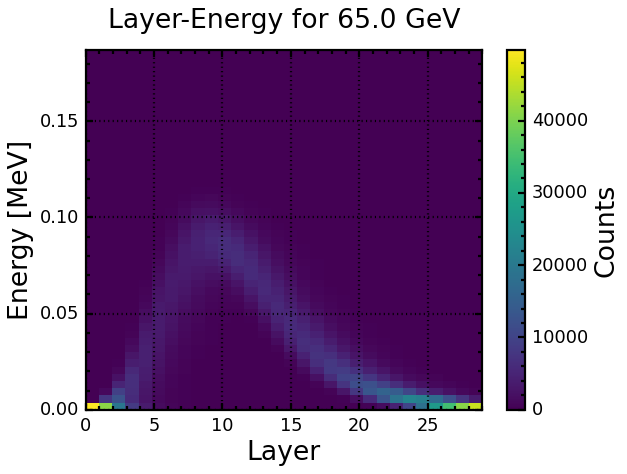

In [5]:
#2D hist Layer-Energy
for i_E, E_truth in enumerate(Energy_Train):
    mask = (E_truth_train == E_truth)
    E_layers = E_layers_train[mask]
    E_sum = np.sum(E_layers, axis=1) + 1e-6
    data = np.array(E_layers_train[mask]/E_sum[:, None])  # shape: (N, 30) 

    x = np.arange(data.shape[1])           # [0, 1, ..., 29]
    X = np.tile(x, data.shape[0])          # 展开 index
    Y = data.flatten()                     # 展开 values    

    plt.figure(figsize=(8,6))
    plt.hist2d(X, Y, bins=(30, 50), cmap='viridis')  # 30 bins for index, 50 for value
    plt.colorbar(label="Counts")    

    plt.xlabel("Layer")
    plt.ylabel("Energy [MeV]")
    plt.title(f"Layer-Energy for {E_truth} GeV")
    plt.show()


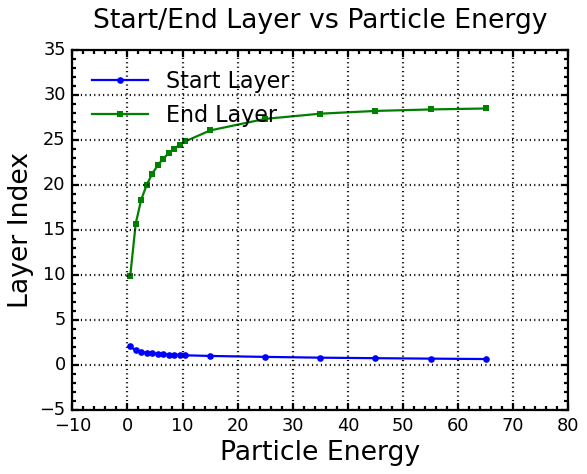

In [6]:
#Graph start/end layer
start_layers = []
end_layers = []

for i_E, E_truth in enumerate(Energy_Train):
    mask = (E_truth_train == E_truth)
    data = np.array(N_layers_train[mask])  # shape: (n_samples, n_layers)
    
    starts = []
    ends = []
    for row in data:
        # 找到所有 >1 的层索引
        idx = np.where(row > 1)[0]
        if len(idx) > 0:
            starts.append(idx[0])   # 第一个
            ends.append(idx[-1])    # 最后一个
    
    # 记录该能量下的平均 start/end
    start_layers.append(np.mean(starts) if starts else np.nan)
    end_layers.append(np.mean(ends) if ends else np.nan)

# 转换为 array
start_layers = np.array(start_layers)
end_layers = np.array(end_layers)

# 画图
plt.figure(figsize=(8,6))
plt.plot(Energy_Train, start_layers, marker='o', label="Start Layer")
plt.plot(Energy_Train, end_layers, marker='s', label="End Layer")

plt.xlabel("Particle Energy")
plt.ylabel("Layer Index")
plt.title("Start/End Layer vs Particle Energy")
plt.legend(loc='upper left')
plt.show()



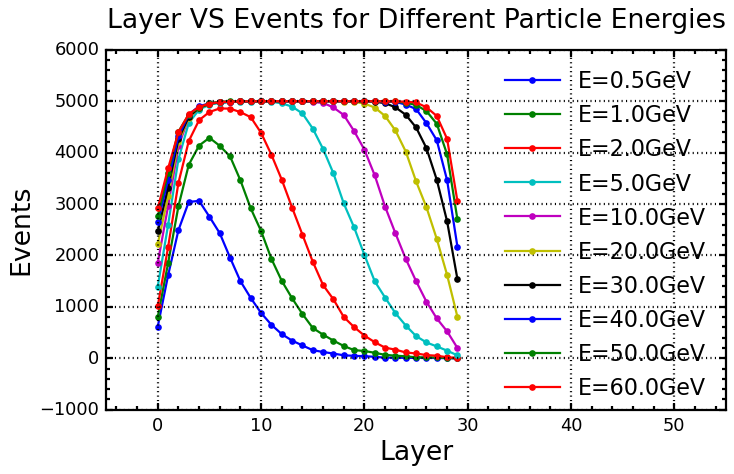

In [7]:
#2D hist layer counts
n_layers = N_layers_train.shape[1]

plt.figure(figsize=(10,6))

for E_truth in Energy_Val:
    mask = (E_truth_validate == E_truth)
    data = np.array(N_layers_validate[mask])   # (n_events, n_layers)

    # 每层 hit 的事例数
    counts = np.sum(data > 1, axis=0)

    plt.plot(np.arange(n_layers), counts, marker='o', label=f"E={E_truth}GeV")

plt.xlabel("Layer")
plt.xlim(-5,55)
plt.ylabel("Events")
plt.title("Layer VS Events for Different Particle Energies")
plt.legend()
plt.show()



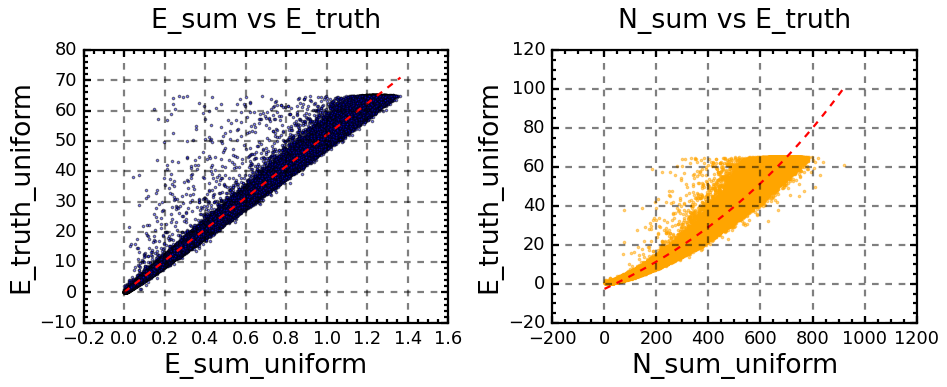

In [8]:
plt.figure(figsize=(12, 5))

coeffs_calibE = np.polyfit(E_sum_uniform, E_truth_uniform, 1)
E_fit_line = np.poly1d(coeffs_calibE)
plt.subplot(1, 2, 1)
plt.scatter(E_sum_uniform, E_truth_uniform, s=5, alpha=0.5)
x_line = np.linspace(min(E_sum_uniform), max(E_sum_uniform), 200)
plt.plot(x_line, E_fit_line(x_line), color="red", linestyle="--", label="Fit Line")
plt.xlabel("E_sum_uniform")
plt.ylabel("E_truth_uniform")
plt.title("E_sum vs E_truth")
plt.grid(True, linestyle="--", alpha=0.5)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform, E_truth_uniform, p0=(1, 0.01, 1))
plt.subplot(1, 2, 2)
plt.scatter(N_sum_uniform, E_truth_uniform, s=5, alpha=0.5, color="orange")
x_line_N = np.linspace(min(N_sum_uniform), max(N_sum_uniform), 200)
plt.plot(x_line_N, exp_func(x_line_N, *coeffs_calibN), color="red", linestyle="--", label="Fit Line")
plt.xlabel("N_sum_uniform")
plt.ylabel("E_truth_uniform")
plt.title("N_sum vs E_truth")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

E_sum_train_calib = E_fit_line(E_sum_train)
E_sum_uniform_calib = E_fit_line(E_sum_uniform)
E_sum_val_calib = E_fit_line(E_sum_val)
N_sum_train_calib = exp_func(N_sum_train, *coeffs_calibN)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
N_sum_val_calib = exp_func(N_sum_val, *coeffs_calibN)

shape (50000, 30) (50000, 30) (50000,) (50000,)
E_particle 0.5 5000
E_particle 1.0 5000
E_particle 2.0 5000
E_particle 5.0 5000
E_particle 10.0 5000
E_particle 20.0 5000
E_particle 30.0 5000
E_particle 40.0 5000
E_particle 50.0 5000
E_particle 60.0 5000


/tmp/ipykernel_894167/1942696021.py:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(ncol=2, fontsize=12)


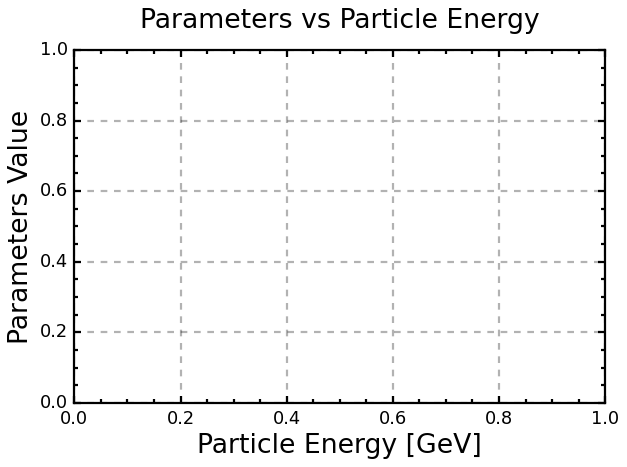

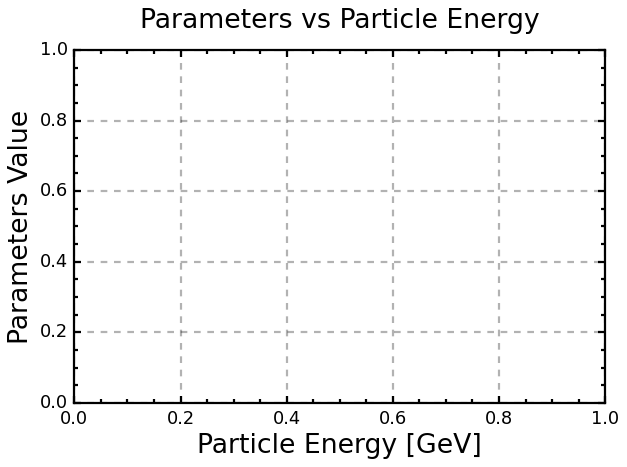

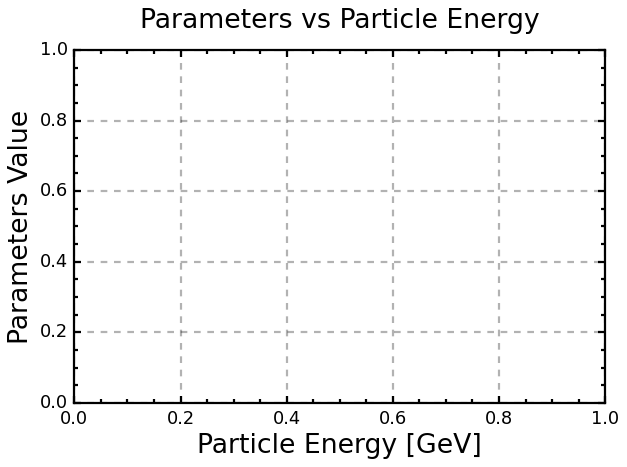

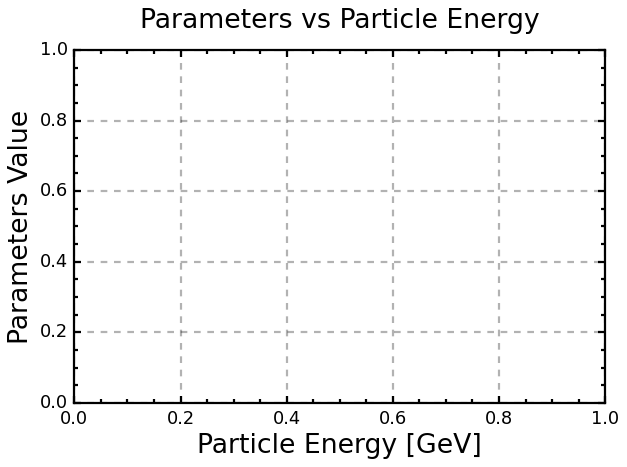

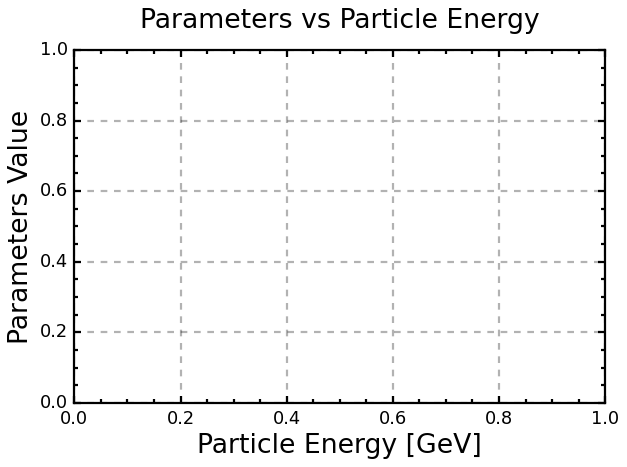

Fitted params for a for layer 0: a=537.7467, b=0.0000, c=-536.9789
Fitted params for a for layer 1: a=660.8263, b=0.0000, c=-660.9301


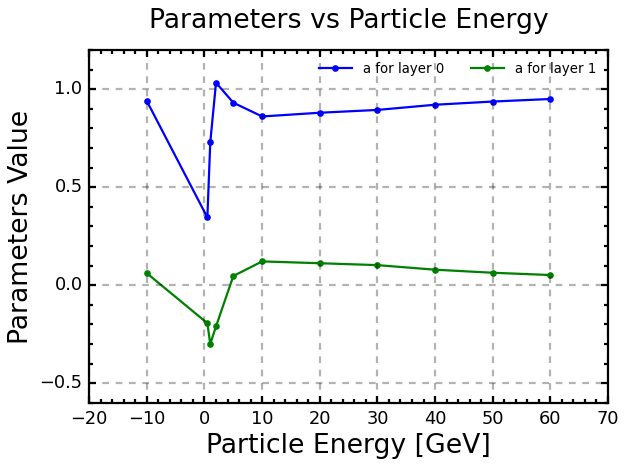

In [9]:
#normal method
Reco_hist = []
Reco_hist_cheat = []
coeffs_all = []
energies_all = []

def ConstructX(E_data, N_data,E_sum_calib,N_sum_calib):
    E_sum = np.sum(E_data, axis=1) + 1e-6  # shape: (Nsample,)
    N_sum = np.sum(N_data, axis=1) + 1e-6  # shape: (Nsample,)
    E_norm = E_data / E_sum[:, None]       # shape: (Nsample, Nlayer)
    N_norm = N_data / N_sum[:, None]       # shape: (Nsample, Nlayer)
    # E_sum_col = E_sum[:, None]
    # N_sum_col = N_sum[:, None]
    # E_exp = np.log(E_data + 1e-6)
    # N_exp = np.log(N_data + 1e-6)
    #X = np.hstack([E_data * np.exp(E_data), N_data])
    X = np.hstack([E_sum_calib[:, np.newaxis],N_sum_calib[:, np.newaxis]])
    #X = np.hstack([E_data, N_data])
    return X
def ConstructY(E_data, N_data,E_truth):
    E_sum = np.sum(E_data,axis=1)
    E_sum_calib = E_fit_line(E_sum)
    y = E_truth #bad idea
    return y
def ConstructModel(E_data,N_data,E_sum_calib,N_sum_calib,E_truth):
    X = ConstructX(E_data, N_data, E_sum_calib,N_sum_calib)
    y = ConstructY(E_data, N_data, E_truth)
    coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    E_reco = X @ coeffs
    return coeffs
def ReconstructE(E_data,N_data,E_sum_calib,N_sum_calib,coeffs):
    E_sum = np.sum(E_data,axis=1)
    E_sum_calib = E_fit_line(E_sum)
    X = ConstructX(E_data, N_data, E_sum_calib,N_sum_calib)
    y = X @ coeffs
    return y
def ConstructHists(E_reco):
    Nbins = 50
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges

#Train
#E_data=np.hstack([E_layers_validate,E_sum_val_calib[:,np.newaxis]])
#N_data=np.hstack([N_layers_validate,N_sum_val_calib[:,np.newaxis]])
E_data = E_layers_validate
N_data = N_layers_validate
print("shape", E_data.shape, E_layers_validate.shape,E_sum_val_calib.shape,E_truth_validate.shape)
E_truth=E_truth_validate
E_Set=Energy_Val
coeffs=ConstructModel(E_data,N_data,E_sum_val_calib,N_sum_val_calib,E_truth)
coeffs_all.append(coeffs)
energies_all.append(-10)
for i_E, E_particle in enumerate(E_Set):
    mask = (E_truth == E_particle)
    print("E_particle", E_particle, len(E_data[mask]))
    E_reco = ReconstructE(E_data[mask], N_data[mask], E_sum_val_calib[mask], N_sum_val_calib[mask], coeffs)
    counts, bin_edges = ConstructHists(E_reco)
    Reco_hist.append({
        "E_truth": E_particle,
        "counts": counts,
        "bin_edges": bin_edges
    })

#cheat method
#E_data=np.hstack([E_layers_validate,E_sum_val_calib[:,np.newaxis]])
#N_data=np.hstack([N_layers_validate,N_sum_val_calib[:,np.newaxis]])
E_data = E_layers_validate
N_data = N_layers_validate
E_truth=E_truth_validate
E_Set=Energy_Val
for i_E, E_particle in enumerate(E_Set):
    mask = (E_truth == E_particle)
    coeffs = ConstructModel(E_data[mask], N_data[mask], E_sum_val_calib[mask], N_sum_val_calib[mask], E_truth[mask])
    coeffs_all.append(coeffs)
    energies_all.append(E_particle)
    E_reco_cheat = ReconstructE(E_data[mask], N_data[mask], E_sum_val_calib[mask], N_sum_val_calib[mask], coeffs)
    counts, bin_edges = ConstructHists(E_reco_cheat)
    if len(E_reco_cheat) == 0:
        continue  # 防止空集
    Reco_hist_cheat.append({
        "E_truth": E_particle,
        "counts": counts,
        "bin_edges": bin_edges
    })

coeffs_all = np.array(coeffs_all)  # shape: (n_energy, 60)


n_coeffs = coeffs_all.shape[1]  # 60
n_plots = 6
coeffs_per_plot = n_coeffs // n_plots  # 6

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 70)

for i in range(n_plots):
    plt.figure(figsize=(8,6))
    start = i * coeffs_per_plot
    end = (start + coeffs_per_plot) if i < n_plots-1 else n_coeffs
    
    for j in range(start, end):
        if j < 30:
            label = f'a for layer {j}'
        else:
            label = f'b for layer {j-30}'
        
        ydata = coeffs_all[:, j]
        plt.plot(energies_all, ydata, marker='o', linestyle='-', label=label)
        energies_all = np.array(energies_all)
        mask = (energies_all >= fit_range[0]) & (energies_all <= fit_range[1])
        x_fit = energies_all[mask]
        y_fit = ydata[mask]
        try:
            popt, _ = curve_fit(exp_func, x_fit, y_fit, p0=(1, 0.01, 0))
            print(f"Fitted params for {label}: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}")
        except RuntimeError:
            print(f"Fit failed for {label}")
    
    plt.xlabel("Particle Energy [GeV]")
    plt.ylabel("Parameters Value")
    plt.title(f"Parameters vs Particle Energy")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(ncol=2, fontsize=12)
    plt.tight_layout()
    plt.show()




In [10]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


Mean: 0.9861955521124953, Peak: 0.964034630230689, RMS: 0.11256476975873435
Initial Gamma Fit Parameters: [np.float64(94.13589324957796), np.float64(3.4590249424804487), np.float64(0.5968312058724643), np.float64(0.11256476975873435)]
Gamma Fit Parameters: [9.41519690e+01 3.45902494e+01 3.26302513e-01 1.91473758e-02]
Gamma Fit Peak: 0.969467641180384 ± 0.0017795278438881386, Resolution: 0.11615897995011845 ± 0.0013433012882419799


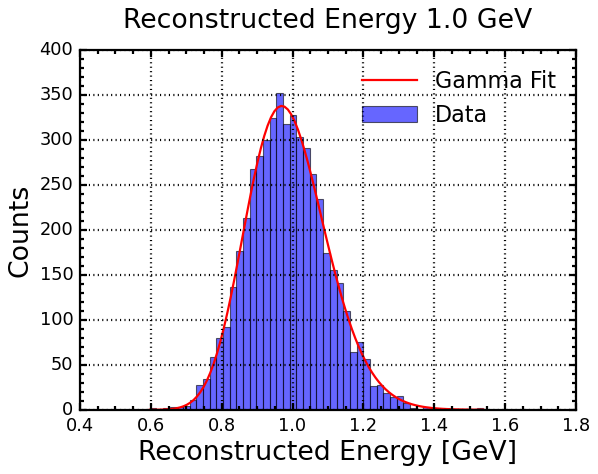

In [11]:
#This cell is left here for debug
i_E = 1  # Example index, change as needed
Hist = Reco_hist_cheat[i_E]
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all("E_reco",Hist["E_truth"],Hist["counts"],Hist["bin_edges"])





Mean: 0.46946764226537463, Peak: 0.44994307537740663, RMS: 0.13396301532830426
Initial Gamma Fit Parameters: [np.float64(107.72769194420644), np.float64(3.9252977229352912), np.float64(-0.05637707676036363), np.float64(0.13396301532830426)]
Gamma Fit Parameters: [ 1.07346806e+02  1.37960462e+01 -2.27798344e-02  3.57239446e-02]
Gamma Fit Peak: 0.4343454125873833 ± 0.0022565995450713684, Resolution: 0.30549315876835365 ± 0.00483745508845287


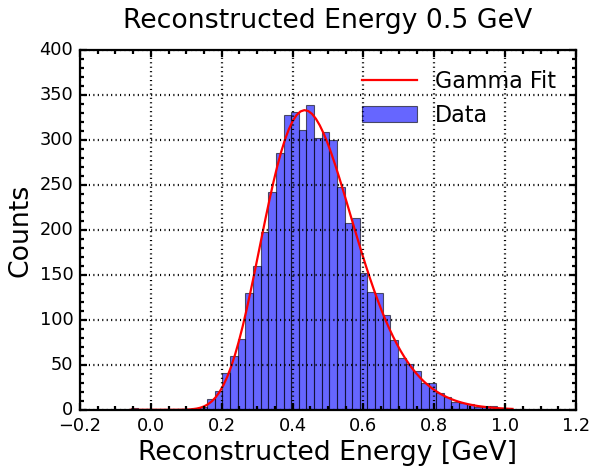

Mean: 0.9900348371920296, Peak: 0.9711883770949603, RMS: 0.18973806712914787
Initial Gamma Fit Parameters: [np.float64(150.6631659220135), np.float64(3.355620822540113), np.float64(0.3533458283049472), np.float64(0.18973806712914787)]
Gamma Fit Parameters: [1.50569398e+02 1.71198500e+01 2.04922561e-01 4.59392604e-02]
Gamma Fit Peak: 0.9454565482179058 ± 0.004620865295279413, Resolution: 0.20104459533077348 ± 0.004105262204513225


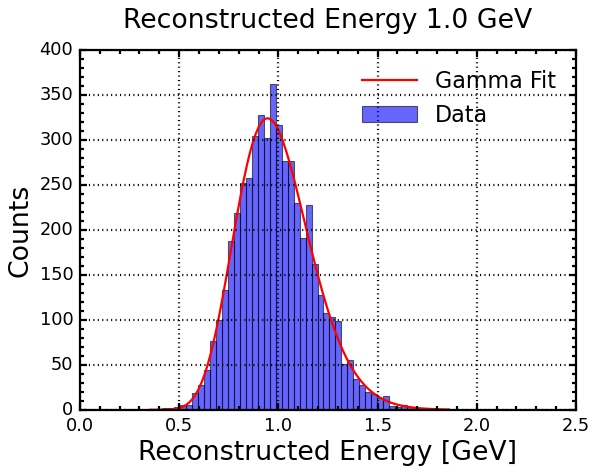

Mean: 2.0177735265187637, Peak: 1.9744641167534032, RMS: 0.2646016506463429
Initial Gamma Fit Parameters: [np.float64(190.21128178308817), np.float64(3.1115893174393263), np.float64(1.1944418569907906), np.float64(0.2646016506463429)]
Gamma Fit Parameters: [1.90220210e+02 3.11158932e+01 5.37848338e-01 4.77496562e-02]
Gamma Fit Peak: 1.975871882231615 ± 0.005852273032972464, Resolution: 0.13480394550606564 ± 0.002213319639117315


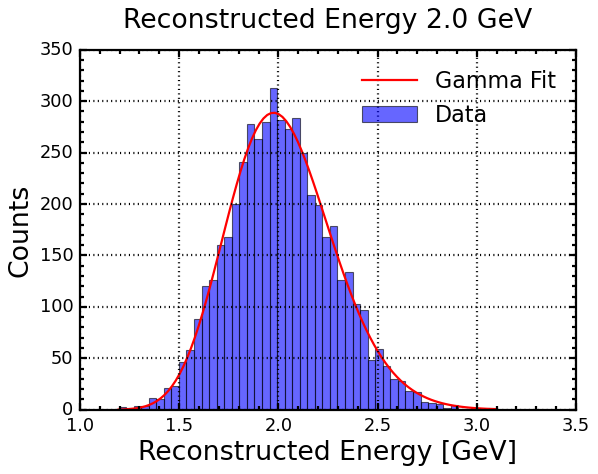

Mean: 5.076328774100614, Peak: 4.999051135302659, RMS: 0.416185426201787
Initial Gamma Fit Parameters: [np.float64(332.7694753117503), np.float64(3.4652305369302714), np.float64(3.634150326200842), np.float64(0.416185426201787)]
Gamma Fit Parameters: [3.35474832e+02 3.46523054e+01 2.55856107e+00 7.29889528e-02]
Gamma Fit Peak: 5.0148075961778265 ± 0.01229373081359193, Resolution: 0.08567792191922992 ± 0.001765982566976673


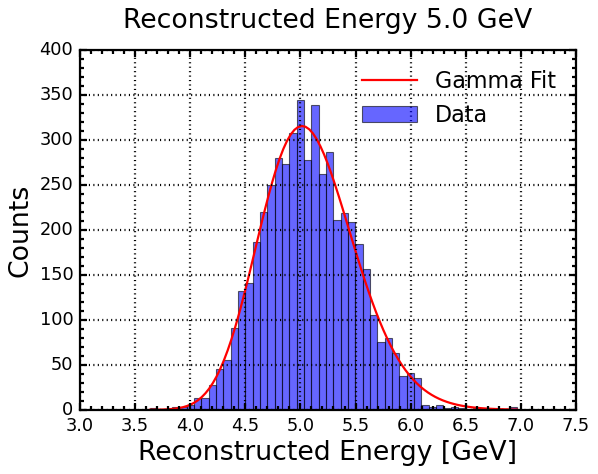

Mean: 10.116116740067058, Peak: 10.039785957800845, RMS: 0.5896207560483174
Initial Gamma Fit Parameters: [np.float64(479.08121767163203), np.float64(4.4375596816953955), np.float64(7.499639445536289), np.float64(0.5896207560483174)]
Gamma Fit Parameters: [4.77329931e+02 4.43755968e+01 6.25664979e+00 8.77663660e-02]
Gamma Fit Peak: 10.063568298861124 ± 0.011333896723354308, Resolution: 0.058096266252752576 ± 0.0007845668023935996


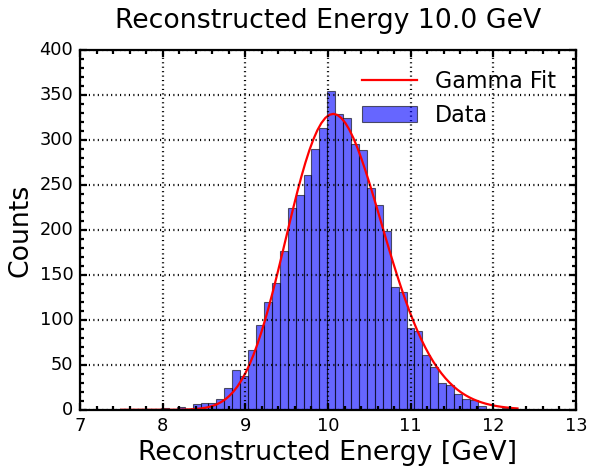

Mean: 20.093938608778785, Peak: 20.08777827738372, RMS: 0.8314013020935964
Initial Gamma Fit Parameters: [np.float64(702.1094529049092), np.float64(3.4725875986130372), np.float64(17.20682475765783), np.float64(0.8314013020935964)]
Gamma Fit Parameters: [6.98901650e+02 3.47258760e+01 1.52835883e+01 1.40009034e-01]
Gamma Fit Peak: 20.005515606013947 ± 0.016125952543003738, Resolution: 0.041241353992706654 ± 0.0005688634070101865


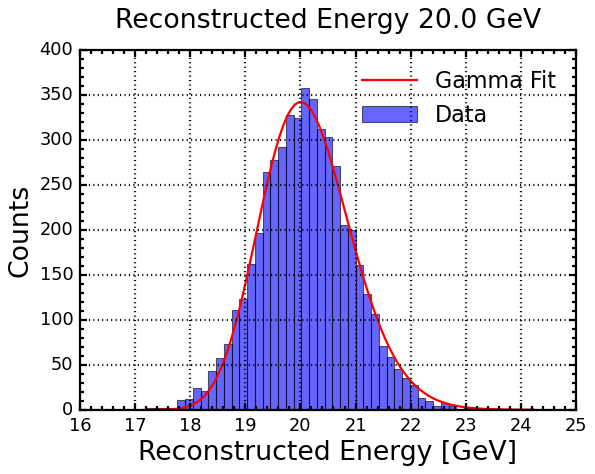

Mean: 30.05426266879902, Peak: 29.624299745852245, RMS: 1.042655476107674
Initial Gamma Fit Parameters: [np.float64(930.7292795935351), np.float64(5.148168336309568), np.float64(24.686496761021715), np.float64(1.042655476107674)]
Gamma Fit Parameters: [9.30589701e+02 5.14816834e+01 2.26362581e+01 1.45413139e-01]
Gamma Fit Peak: 29.976958130371848 ± 0.03132513947595849, Resolution: 0.034805065672922006 ± 0.0007136268161815739


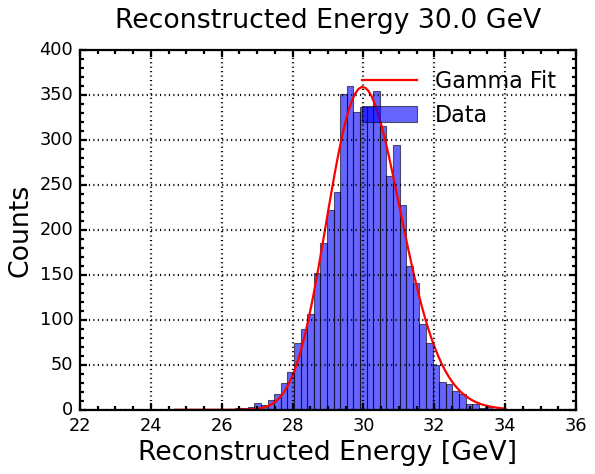

Mean: 39.982778105769135, Peak: 40.149773359905375, RMS: 1.2013797254437772
Initial Gamma Fit Parameters: [np.float64(1103.2761986720886), np.float64(4.734051811694086), np.float64(34.29538423999948), np.float64(1.2013797254437772)]
Gamma Fit Parameters: [1.10256154e+03 4.73405181e+01 3.18242338e+01 1.74024180e-01]
Gamma Fit Peak: 39.888604502905466 ± 0.02127831198810339, Resolution: 0.030017689279789605 ± 0.0003656738406800957


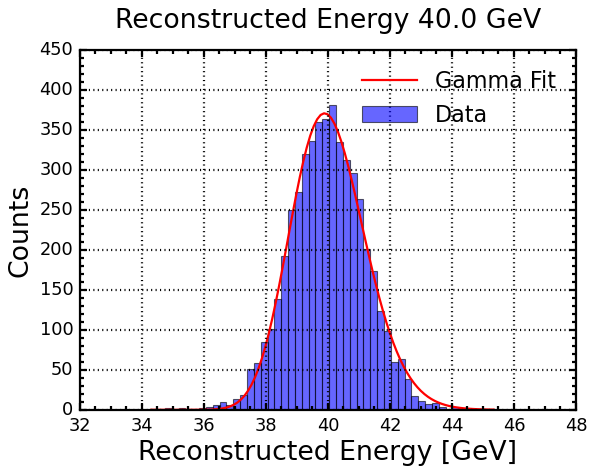

Mean: 49.94646097338309, Peak: 50.18607903826843, RMS: 1.3495430017462333
Initial Gamma Fit Parameters: [np.float64(1162.9550749859561), np.float64(5.080110061455825), np.float64(43.090633991844754), np.float64(1.3495430017462333)]
Gamma Fit Parameters: [1.15634190e+03 5.08011006e+01 4.05798401e+01 1.86381962e-01]
Gamma Fit Peak: 49.86186693232861 ± 0.03417315800751236, Resolution: 0.026642311679331742 ± 0.00046711375745401624


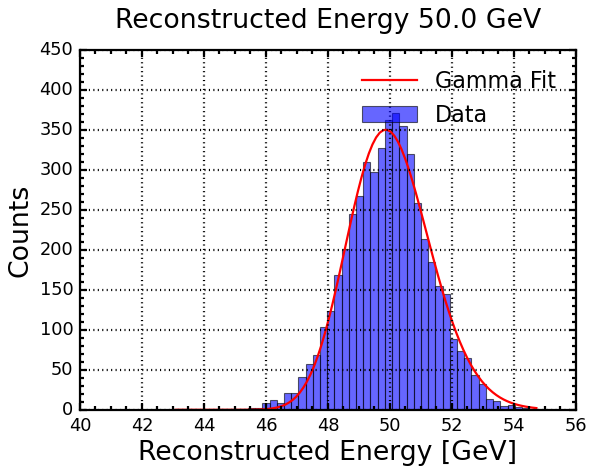

Mean: 59.853174450547954, Peak: 59.35638539025121, RMS: 1.5130687104506493
Initial Gamma Fit Parameters: [np.float64(1409.9599121062847), np.float64(4.897160551429751), np.float64(52.44343405012635), np.float64(1.5130687104506493)]
Gamma Fit Parameters: [1.40285599e+03 4.89716055e+01 4.95261194e+01 2.13248315e-01]
Gamma Fit Peak: 59.75598338717656 ± 0.03675050095503646, Resolution: 0.02497332569325222 ± 0.0004198386013573629


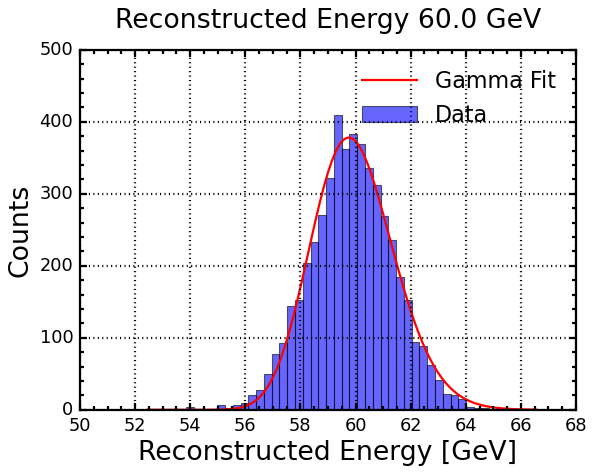

In [13]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
results = []
CONF="LW" #LW or cheat
for i_E in range(len(Energy_Val)):
    mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
    mean_log_normal,mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
    if CONF=="cheat":
        Hist = Reco_hist_cheat[i_E]
    elif CONF=="LW":
        Hist = Reco_hist[i_E]
    else:
        raise ValueError("Unknown CONF")
    mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Hist["E_truth"],Hist["counts"],Hist["bin_edges"])
    results.append({
        "ParticleEnergy": Energy_Val[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath_Validate, f"RecoE_{CONF}_Fit.csv")
df.to_csv(outputfile_name, index=False)

